In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import kurtosis
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, ShuffleSplit, StratifiedShuffleSplit
from sklearn.feature_selection import RFE
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
Iterate through the folders
  go to path
  iterate through folders
    get csv files
      parse csv files with some function to get vector
      add the file name as the label
  now we have a dataframe

SyntaxError: ignored

In [3]:
os.chdir("/content/drive/MyDrive/Network Security/data")
os.getcwd()
os.listdir() 

['Untitled.pklg',
 'text',
 'phonecallno',
 'pickup',
 'duo',
 'outdoorwalk',
 'spotify',
 'strength',
 'ECG',
 '{1}']

In [4]:
print(os.getcwd())

for file in os.listdir():
  if os.path.isfile(os.path.join(file)): 
    # print(file)
    print("Found ")
  else: 
    # call some function to add to a global dataframe
    print(file)
    os.chdir(file)
    # df = pd.DataFrame()

    for file in os.listdir(): 
      if file.endswith('.csv'):
        try: 
          df = pd.read_csv(file)
          break
          # print(df.head())
        except: 
          print(file)

    os.chdir("..")


/content/drive/.shortcut-targets-by-id/1NAgrWTUWWB-P3s7Qk9j1mvaToubCXuJu/Network Security/data
Found 
text
phonecallno
pickup
duo
outdoorwalk
spotify
strength
ECG
Found 


In [5]:
def get_data_from_path(file): 
  os.chdir(file)
  df = pd.DataFrame()

  for file in os.listdir(): 
    df.append(pd.read_csv(file))

  os.chdir("..")

  return df

In [6]:
print(df.head())

   No.  Time Source Destination Protocol  Length  \
0    1   0.0    NaN         NaN   PKTLOG      20   
1    2   0.0    NaN         NaN   PKTLOG      32   
2    3   0.0    NaN         NaN   PKTLOG      18   
3    4   0.0    NaN         NaN   PKTLOG      16   
4    5   0.0    NaN         NaN   PKTLOG      83   

                                                Info  
0                                Product: iPhone15,2  
1                    Firmware Version: 20.1.488.6352  
2                                  Chipset: BCM_4387  
3                                    Transport: PCIe  
4  Firmware Filename: BCM4387C2_20.1.488.6352_PCI...  


In [ ]:
print(df)

       No.        Time             Source        Destination Protocol  Length  \
0        1       0.000                NaN                NaN   PKTLOG      20   
1        2       0.000                NaN                NaN   PKTLOG      32   
2        3       0.000                NaN                NaN   PKTLOG      18   
3        4       0.000                NaN                NaN   PKTLOG      16   
4        5       0.000                NaN                NaN   PKTLOG      83   
...    ...         ...                ...                ...      ...     ...   
1058  1059  230801.748       localhost ()  Apple_a5:7a:93 ()    L2CAP      11   
1059  1060  230801.779  Apple_a5:7a:93 ()       localhost ()    L2CAP      11   
1060  1061  230801.787         controller               host  HCI_EVT      47   
1061  1062  230801.850         controller               host  HCI_EVT       8   
1062  1063  230801.850         controller               host  HCI_EVT      37   

                           

In [7]:
df.drop(df[df['Protocol'] != "L2CAP"].index, inplace = True)
print(df)

       No.        Time             Source        Destination Protocol  Length  \
66      67  230774.537          remote ()       localhost ()    L2CAP      18   
67      68  230774.538       localhost ()          remote ()    L2CAP      80   
68      69  230774.547       localhost ()          remote ()    L2CAP      88   
71      72  230774.625          remote ()       localhost ()    L2CAP      80   
72      73  230774.638       localhost ()          remote ()    L2CAP      11   
...    ...         ...                ...                ...      ...     ...   
1052  1053  230801.696  Apple_a5:7a:93 ()       localhost ()    L2CAP      80   
1053  1054  230801.697  Apple_a5:7a:93 ()       localhost ()    L2CAP      88   
1054  1055  230801.697       localhost ()  Apple_a5:7a:93 ()    L2CAP      80   
1058  1059  230801.748       localhost ()  Apple_a5:7a:93 ()    L2CAP      11   
1059  1060  230801.779  Apple_a5:7a:93 ()       localhost ()    L2CAP      11   

                           

In [8]:
# so we probably want this to be a function that takes in the file name and
# and appends to some global dictionary the values we care about
# maybe we create a dictionary of dictionaries???
# similar to packets_to_timesize_tuples in https://github.com/ldsec/every_byte_matters/blob/master/inference_attack/lib/build_datasets.py
# but for some reason they have a double for loop ??
def packets_to_timesize_tuples(packets):
    xy = dict(xs=[], ys=[])
    
    t0 = -1000

    for index, row in packets.iterrows(): 
      t = float(row['Time'])

      if t0 == -1000: 
        t0 = t
      y = int(row['Length'])

      direction = 1

      if not "localhost ()" in row['Source']: 
        direction = -1

      xy['xs'].append(t-t0)
      xy['ys'].append(direction * y)

    return xy


In [9]:
xy = packets_to_timesize_tuples(df)

In [10]:
print(xy)

{'xs': [0.0, 0.0009999999892897904, 0.009999999980209395, 0.08799999998882413, 0.10099999999511056, 0.14799999998649582, 18.45900000000256, 18.45900000000256, 18.481999999989057, 18.481999999989057, 18.573999999993248, 18.629999999975553, 18.660999999992782, 18.660999999992782, 18.660999999992782, 18.671999999991385, 18.67499999998836, 18.69000000000233, 18.720000000001164, 18.720999999990454, 18.720999999990454, 18.722999999998137, 18.777999999991152, 18.80799999998999, 18.820999999996275, 18.913000000000466, 19.107999999978347, 19.11099999997532, 19.11099999997532, 19.114999999990687, 19.168999999994412, 19.168999999994412, 19.169999999983702, 19.197999999974854, 19.20999999999185, 19.347999999998137, 22.4769999999844, 22.4769999999844, 22.527000000001863, 22.527000000001863, 22.655999999988126, 22.679999999993015, 22.70999999999185, 22.71099999998114, 22.711999999999534, 22.739999999990687, 22.739999999990687, 22.756999999983236, 22.769999999989523, 22.79999999998836, 22.80099999997

In [11]:
def extract_features(xy, unique_from=46, unique_to=1006, unique_granularity=1, unique_deltas=[1005, 46, 0]): # dataset is {'xs': [packet1, packet2,...], 'ys': [packet1, packet2,...]} where x is time and y is size

    xs = xy['xs']
    ys = xy['ys']
    f = dict()
    
    bins = np.arange(0, 1000, step = unique_granularity)

    def deltas(serie):
        out = []
        i = 1
        while i<len(serie):
            out.append(serie[i]-serie[i-1])
            i += 1
        return out

    def extract_bins(x):
        if x > bins[-1]:
            b = bins[-1] + 10
        else:
            b = bins[np.digitize(x, bins, right = True)]
        return b

    def take(arr, n=30):
        if len(arr) > n:
            return arr[:30]
        return arr

    def stats(key, data):
        if len(data) == 0:
            data=[-1]
        f['min_'+key] = np.min(data)
        f['mean_'+key] = np.mean(data)
        f['max_'+key] = np.max(data)
        f['count_'+key] = len(data)
        f['std_'+key] = np.std(data)
        #f['kurtosis_'+key] = kurtosis(data)

    def avgIPT(xs, ys, incoming=True):
        def condition(y):
            if incoming and y>=0:
                return True
            if not incoming and y<0:
                return True
            return False
        zipped = [xy for xy in zip(xs, ys) if condition(xy[1])]
        P = len(zipped)

        if P == 1:
            return zipped[0][1]
        nom = sum(deltas([xy[0] for xy in zipped]))

        return nom/(P-1)

    f['avgipt_incoming'] = avgIPT(xs, ys, True)
    f['avgipt_outgoing'] = avgIPT(xs, ys, False)


    # general statistics
    stats("sizes_non_null", [abs(y) for y in ys if abs(y) > 0])
    stats("sizes_outgoing", [abs(y) for y in ys if y > 0])
    stats("sizes_incoming", [abs(y) for y in ys if y < 0])
    stats("sizes_outgoing2", [abs(y) for y in ys if y > unique_from])
    stats("sizes_incoming2", [abs(y) for y in ys if y < -unique_from])

    # unique packet lengths [Liberatore and Levine; Herrmann et al.]
    lengths = dict()
    for i in range(unique_from, unique_to):
        lengths[str(i)] = 0
    for y in ys:
        if str(abs(y)) in lengths:
            lengths[str(abs(y))] += 1

    lengths_array = list(lengths.values())
    # stats("count_sizes", lengths_array)

    # # global stats about len
    # for l in lengths:
    #     f['count_sizes_'+str(l)] = extract_bins(lengths[l])


    # statistics about timings
    for u in unique_deltas:
        xs_filtered = [xs[i] for i, y in enumerate(ys) if abs(y) > u]
        x_deltas = []
        i=0
        while i<len(xs_filtered):
            x_deltas.append(xs_filtered[i]-xs_filtered[i-1])
            i += 1
        stats("time_deltas_"+str(u), x_deltas)
    return f


In [ ]:
f = extract_features(xy)

NameError: ignored

In [ ]:
print(f)

{'avgipt_incoming': 0.21093023255807636, 'avgipt_outgoing': 0.22329508196719974, 'min_sizes_non_null': 8, 'mean_sizes_non_null': 391.27272727272725, 'max_sizes_non_null': 2581, 'count_sizes_non_null': 253, 'std_sizes_non_null': 581.7323120921578, 'min_sizes_outgoing': 8, 'mean_sizes_outgoing': 98.37692307692308, 'max_sizes_outgoing': 2009, 'count_sizes_outgoing': 130, 'std_sizes_outgoing': 213.77703213267702, 'min_sizes_incoming': 11, 'mean_sizes_incoming': 700.8373983739838, 'max_sizes_incoming': 2581, 'count_sizes_incoming': 123, 'std_sizes_incoming': 679.1776396817243, 'min_sizes_outgoing2': 61, 'mean_sizes_outgoing2': 121.2135922330097, 'max_sizes_outgoing2': 2009, 'count_sizes_outgoing2': 103, 'std_sizes_outgoing2': 234.8793803431813, 'min_sizes_incoming2': 68, 'mean_sizes_incoming2': 818.9428571428572, 'max_sizes_incoming2': 2581, 'count_sizes_incoming2': 105, 'std_sizes_incoming2': 667.1140521975652, 'min_count_sizes': 0, 'mean_count_sizes': 0.15625, 'max_count_sizes': 71, 'coun

In [12]:
def build_features_labels_dataset():
  # maybe get filepath and iterate through that way? 
  # we start at the data file path
  # extract the files
  df = pd.DataFrame()
 
  for folder_label in os.listdir(): # this is in /data
    
    if os.path.isdir(os.path.join(folder_label)):
      os.chdir(folder_label)

      for file in os.listdir(): 
        if file.endswith('.csv'):
          df1 = pd.read_csv(file)
          df1.drop(df1[df1['Protocol'] != "L2CAP"].index, inplace = True)
          f = extract_features(packets_to_timesize_tuples(df1))
          # print(f)
          f['Label'] = folder_label

          # df.append(f, ignore_index=True)
          df = pd.concat([df, pd.DataFrame(f, index=[0])], ignore_index=True)
          # print(df)
          print(file)
          # try: 
          #   f = extract_features(packets_to_timesize_tuples(pd.read_csv(file)))
          #   print(f)
          #   f['Label'] = folder_label

          #   df.append(f)

          #   print(file)

          # except: 
          #   print("failed on file named: {}".format(file))

      os.chdir("..")

  return df

In [13]:
data = build_features_labels_dataset()

textset1.csv
textset2.csv
textset3.csv
textset4.csv
textset5.csv
textset6.csv
textset7.csv
textset8.csv
textset9.csv
textset10.csv
nopickup.csv
nopickup2.csv
nopickup3.csv
nopickup4.csv
nopickup5.csv
nopickup6.csv
nopickup7.csv
nopickup8.csv
nopickup9.csv
nopickup10.csv
phonecallpickup.csv
phonecallpickup2.csv
phonecallpickup3.csv
phonecallpickup4.csv
phonecallpickup5.csv
phonecallpickup6.csv
phonecallpickup7.csv
phonecallpickup8.csv
phonecallpickup9.csv
phonecallpickup10.csv
duotest1.csv
duotest2.csv
duotest3.csv
duotest4.csv
duotest6.csv
duotest7.csv
duotest8.csv
duotest9.csv
duotest10.csv
nopickup.csv
nopickup2.csv
nopickup3.csv
nopickup4.csv
nopickup5.csv
nopickup6.csv
nopickup7.csv
nopickup8.csv
nopickup9.csv
nopickup10.csv
spot10.csv
spot9.csv
spot8.csv
spot7.csv
spot6.csv
spot5.csv
spot4.csv
spot3.csv
spot2.csv
spot1.csv
strength1.csv
strength2.csv
strength3.csv
strength4.csv
strength5.csv
strength6.csv
strength7.csv
strength8.csv
strength9.csv
strength10.csv
ECG10.csv
ECG9.csv


In [14]:
def print_full(x):
    for i in x.columns: 
      print(i)

print_full(data)

avgipt_incoming
avgipt_outgoing
min_sizes_non_null
mean_sizes_non_null
max_sizes_non_null
count_sizes_non_null
std_sizes_non_null
min_sizes_outgoing
mean_sizes_outgoing
max_sizes_outgoing
count_sizes_outgoing
std_sizes_outgoing
min_sizes_incoming
mean_sizes_incoming
max_sizes_incoming
count_sizes_incoming
std_sizes_incoming
min_sizes_outgoing2
mean_sizes_outgoing2
max_sizes_outgoing2
count_sizes_outgoing2
std_sizes_outgoing2
min_sizes_incoming2
mean_sizes_incoming2
max_sizes_incoming2
count_sizes_incoming2
std_sizes_incoming2
min_time_deltas_1005
mean_time_deltas_1005
max_time_deltas_1005
count_time_deltas_1005
std_time_deltas_1005
min_time_deltas_46
mean_time_deltas_46
max_time_deltas_46
count_time_deltas_46
std_time_deltas_46
min_time_deltas_0
mean_time_deltas_0
max_time_deltas_0
count_time_deltas_0
std_time_deltas_0
Label


In [15]:
print(data.head)

<bound method NDFrame.head of     avgipt_incoming  avgipt_outgoing  min_sizes_non_null  mean_sizes_non_null  \
0          0.083299         0.082838                  11           187.029661   
1          0.045043         0.046447                  11            73.181034   
2          0.066926         0.070663                  11            71.282799   
3          0.066681         0.067178                  11            69.552198   
4          0.046418         0.049759                  11           360.516949   
..              ...              ...                 ...                  ...   
74         0.046455         0.049963                  11           555.280702   
75         0.261659         0.272750                   6           275.002481   
76         0.044783         0.048548                  11           558.348315   
77         0.482291         0.551594                  10           476.865385   
78         0.346337         0.380910                  10           492.645503  

In [17]:
print(data.columns)

Index(['avgipt_incoming', 'avgipt_outgoing', 'min_sizes_non_null',
       'mean_sizes_non_null', 'max_sizes_non_null', 'count_sizes_non_null',
       'std_sizes_non_null', 'min_sizes_outgoing', 'mean_sizes_outgoing',
       'max_sizes_outgoing', 'count_sizes_outgoing', 'std_sizes_outgoing',
       'min_sizes_incoming', 'mean_sizes_incoming', 'max_sizes_incoming',
       'count_sizes_incoming', 'std_sizes_incoming', 'min_sizes_outgoing2',
       'mean_sizes_outgoing2', 'max_sizes_outgoing2', 'count_sizes_outgoing2',
       'std_sizes_outgoing2', 'min_sizes_incoming2', 'mean_sizes_incoming2',
       'max_sizes_incoming2', 'count_sizes_incoming2', 'std_sizes_incoming2',
       'min_time_deltas_1005', 'mean_time_deltas_1005', 'max_time_deltas_1005',
       'count_time_deltas_1005', 'std_time_deltas_1005', 'min_time_deltas_46',
       'mean_time_deltas_46', 'max_time_deltas_46', 'count_time_deltas_46',
       'std_time_deltas_46', 'min_time_deltas_0', 'mean_time_deltas_0',
       'max_time_

In [18]:
split = ShuffleSplit(n_splits = 1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data['Label']): 
  data_train_set = data.loc[train_index]
  data_test_set = data.loc[test_index]

In [19]:
data_train_set_labels = data_train_set['Label'].copy()
data_train_set_values = data_train_set.drop(['Label'], axis=1)

data_test_set_labels = data_test_set['Label'].copy()
data_test_set_values = data_test_set.drop(['Label'], axis=1)

In [20]:
def naive_bayes(X_train, X_test, y_train, y_test):
    gnb = GaussianNB()
    gnb.fit(X_train, y_train) 
    y_pred = gnb.predict(X_test)

    accuracy = metrics.accuracy_score(y_test, y_pred)

    return [accuracy, y_pred]

def svm(X_train, X_test, y_train, y_test, kernel='linear'):
    clf = SVC(kernel=kernel)
    clf.fit(X_train, y_train) 
    y_pred = clf.predict(X_test)

    accuracy = metrics.accuracy_score(y_test, y_pred)

    return [accuracy, y_pred]

def k_nearest_neighbors(X_train, X_test, y_train, y_test, k=10):
    neigh = KNeighborsClassifier(n_neighbors=3)
    neigh.fit(X_train, y_train)
    y_pred = neigh.predict(X_test)

    accuracy = metrics.accuracy_score(y_test, y_pred)

    return [accuracy, y_pred]

In [21]:
nb_model = naive_bayes(data_train_set_values, data_test_set_values, data_train_set_labels, data_test_set_labels)

In [22]:
svm_model = svm(data_train_set_values, data_test_set_values, data_train_set_labels, data_test_set_labels)

In [23]:
knearest_model = k_nearest_neighbors(data_train_set_values, data_test_set_values, data_train_set_labels, data_test_set_labels)

In [24]:
print(nb_model)

[0.9375, array(['duo', 'text', 'pickup', 'duo', 'phonecallno', 'pickup',
       'outdoorwalk', 'ECG', 'text', 'phonecallno', 'spotify', 'duo',
       'strength', 'duo', 'strength', 'outdoorwalk'], dtype='<U11')]


In [25]:
print(svm_model)

[0.75, array(['duo', 'text', 'pickup', 'duo', 'outdoorwalk', 'pickup',
       'outdoorwalk', 'ECG', 'text', 'outdoorwalk', 'spotify', 'duo',
       'strength', 'duo', 'strength', 'phonecallno'], dtype=object)]


In [26]:
print(knearest_model)

[0.5, array(['duo', 'duo', 'pickup', 'duo', 'outdoorwalk', 'pickup', 'text',
       'ECG', 'duo', 'outdoorwalk', 'text', 'spotify', 'strength', 'duo',
       'strength', 'phonecallno'], dtype=object)]


###Lets try and do some RFE stuff found here: https://github.com/ldsec/every_byte_matters/blob/master/inference_attack/action_id_wearables.py

In [27]:
def find_best_rfe_params(X, y, feature_names, n_trees=30, rfe_steps=20):
    n, result = [], []
    
    sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

    print(feature_names)

    X = np.array(X)
    y = np.array(y)

    for rfe_nfeatures in [1,2,5,10,20,30,40,50,60,70,80,90,100]:
        i = 0
        scores = []
        for train_index, test_index in sss.split(X, y):
            print("Fold", i, end="\r")

            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            s, feature_importance, _, predicted_probabilites, clf_model = random_forest(feature_names, X_train, y_train, X_test, y_test, n_trees=n_trees, rfe_nfeatures=rfe_nfeatures, rfe_steps=rfe_steps)

            scores.append(s)
            i += 1

        # average scores
        score = {k: np.mean([value[k] for value in scores]) for k in scores[0]}

        n.append(rfe_nfeatures)
        result.append(score)
        print("N:", rfe_nfeatures, "Score:", score)

    return n, [r['accuracy'] for r in result], feature_importance, predicted_probabilites, clf_model


def random_forest(features_names, X_train, y_train, X_test, y_test, n_trees=100, rfe_nfeatures=3, rfe_steps=10):
    clf=RandomForestClassifier(n_jobs=8, n_estimators=n_trees, random_state=0)
    selector = RFE(estimator=clf, n_features_to_select=rfe_nfeatures, step=rfe_steps)
    selector = selector.fit(X_train, y_train)
    X_train = selector.transform(X_train)
    X_test = selector.transform(X_test)
    
    clf2=RandomForestClassifier(n_jobs=8, n_estimators=n_trees, random_state=0)
    clf2.fit(X_train, y_train)
    y_pred=clf2.predict(X_test)
    predicted_probas = clf2.predict_proba(X_test)

    scores = dict(
        accuracy = metrics.accuracy_score(y_test, y_pred),
        precision = metrics.precision_score(y_test, y_pred, average='micro'),
        recall = metrics.recall_score(y_test, y_pred, average='micro'),
        f1score = metrics.f1_score(y_test, y_pred, average='micro'),
    )
    selected_features = []
    i = 0
    while i<len(features_names):
        if selector.support_[i] == 1:
            selected_features.append(features_names[i])
        i+=1

    feature_importance = sorted(zip(clf2.feature_importances_, selected_features), reverse=True)

    return scores, feature_importance, y_pred, predicted_probas, clf2

In [28]:
n_1, n_2, feature_importance, predicted_probabilities, clf_model = find_best_rfe_params(data.drop(['Label'], axis=1), data['Label'], data.columns[0:-1])

Index(['avgipt_incoming', 'avgipt_outgoing', 'min_sizes_non_null',
       'mean_sizes_non_null', 'max_sizes_non_null', 'count_sizes_non_null',
       'std_sizes_non_null', 'min_sizes_outgoing', 'mean_sizes_outgoing',
       'max_sizes_outgoing', 'count_sizes_outgoing', 'std_sizes_outgoing',
       'min_sizes_incoming', 'mean_sizes_incoming', 'max_sizes_incoming',
       'count_sizes_incoming', 'std_sizes_incoming', 'min_sizes_outgoing2',
       'mean_sizes_outgoing2', 'max_sizes_outgoing2', 'count_sizes_outgoing2',
       'std_sizes_outgoing2', 'min_sizes_incoming2', 'mean_sizes_incoming2',
       'max_sizes_incoming2', 'count_sizes_incoming2', 'std_sizes_incoming2',
       'min_time_deltas_1005', 'mean_time_deltas_1005', 'max_time_deltas_1005',
       'count_time_deltas_1005', 'std_time_deltas_1005', 'min_time_deltas_46',
       'mean_time_deltas_46', 'max_time_deltas_46', 'count_time_deltas_46',
       'std_time_deltas_46', 'min_time_deltas_0', 'mean_time_deltas_0',
       'max_time_

Written {1}/eps


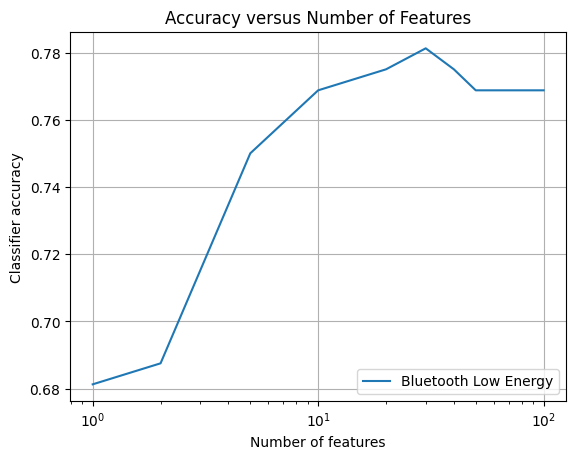

In [29]:
xs, ys_ble = n_1, n_2
plt.figure()
plt.errorbar(xs, ys_ble, label='Bluetooth Low Energy')
plt.xlabel('Number of features')
plt.ylabel('Classifier accuracy')
plt.xscale('log')
plt.title('Accuracy versus Number of Features')
plt.legend(loc='lower right')
plt.grid()
# plt.ylim([0, 1])
plt.savefig('{1}', format='png')
plt.savefig('{1}'.replace('.png', '.eps'), format='eps')
print("Written {1}/eps")

In [30]:
print(feature_importance)

[(0.08255772258122712, 'count_sizes_incoming2'), (0.06710415226337546, 'min_time_deltas_0'), (0.05120758128235862, 'min_time_deltas_46'), (0.050550820680263536, 'mean_sizes_incoming'), (0.04650734619483079, 'avgipt_incoming'), (0.04406126784436141, 'count_time_deltas_46'), (0.04282413333076431, 'max_sizes_incoming'), (0.038674942707063356, 'count_time_deltas_0'), (0.03719714471394174, 'std_sizes_incoming'), (0.035504976717959734, 'std_time_deltas_46'), (0.0354938514849906, 'avgipt_outgoing'), (0.03265842274333239, 'count_sizes_outgoing'), (0.03237179996830979, 'std_time_deltas_0'), (0.032151585587096417, 'count_sizes_non_null'), (0.03027242283474489, 'count_sizes_outgoing2'), (0.029695608030052903, 'max_time_deltas_0'), (0.027814971815969116, 'std_sizes_incoming2'), (0.024939390089980994, 'min_sizes_non_null'), (0.024073350311712958, 'max_sizes_incoming2'), (0.023553873315684183, 'min_sizes_outgoing2'), (0.018768449785138187, 'max_time_deltas_46'), (0.017314314808434008, 'min_sizes_inc

In [31]:
print(predicted_probabilities)

[[0.         0.6        0.12777778 0.10555556 0.         0.
  0.         0.16666667]
 [0.         0.         0.03333333 0.         0.96666667 0.
  0.         0.        ]
 [0.         0.         0.49722222 0.50277778 0.         0.
  0.         0.        ]
 [0.         0.         0.49722222 0.50277778 0.         0.
  0.         0.        ]
 [0.         0.         0.76777778 0.23222222 0.         0.
  0.         0.        ]
 [0.23333333 0.         0.         0.         0.03333333 0.06666667
  0.66666667 0.        ]
 [0.         0.26666667 0.10277778 0.09722222 0.         0.
  0.         0.53333333]
 [0.         0.         0.         0.         0.03333333 0.8
  0.1        0.06666667]
 [0.96666667 0.         0.         0.         0.         0.03333333
  0.         0.        ]
 [0.13333333 0.         0.         0.         0.03333333 0.
  0.83333333 0.        ]
 [0.06666667 0.4        0.07777778 0.08888889 0.         0.
  0.03333333 0.33333333]
 [0.         0.03333333 0.20555556 0.66111111 0.

In [32]:
clf_model.classes_

array(['ECG', 'duo', 'outdoorwalk', 'phonecallno', 'pickup', 'spotify',
       'strength', 'text'], dtype=object)

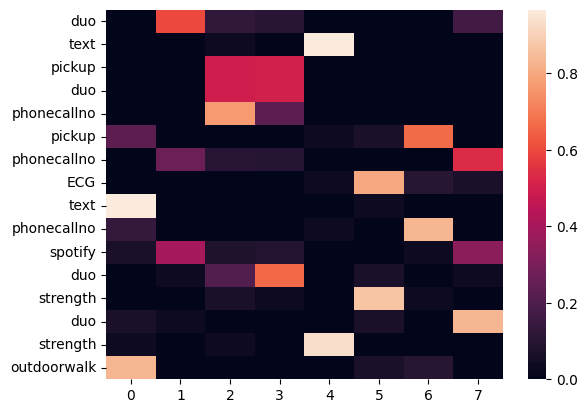

In [33]:
ax = sns.heatmap(predicted_probabilities, yticklabels=data_test_set_labels)
plt.show()

In [34]:
print(data_test_set_labels)

30            duo
0            text
22         pickup
31            duo
18    phonecallno
28         pickup
10    phonecallno
70            ECG
4            text
12    phonecallno
49        spotify
33            duo
67       strength
35            duo
68       strength
45    outdoorwalk
Name: Label, dtype: object


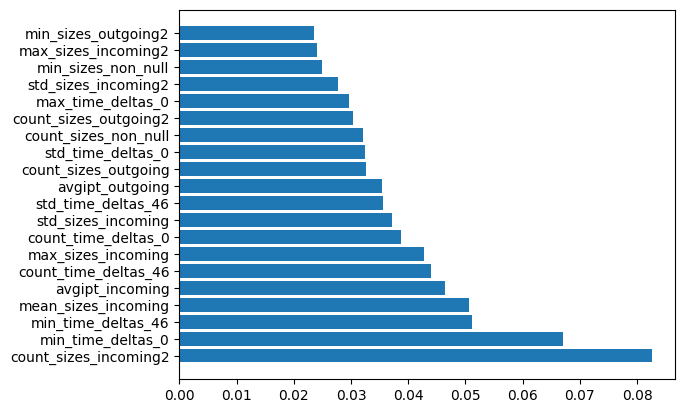

In [35]:
values, labels = zip(*(feature_importance[:20]))
plt.barh(range(len(labels)),values)
plt.yticks(range(len(values)),labels)
plt.show()

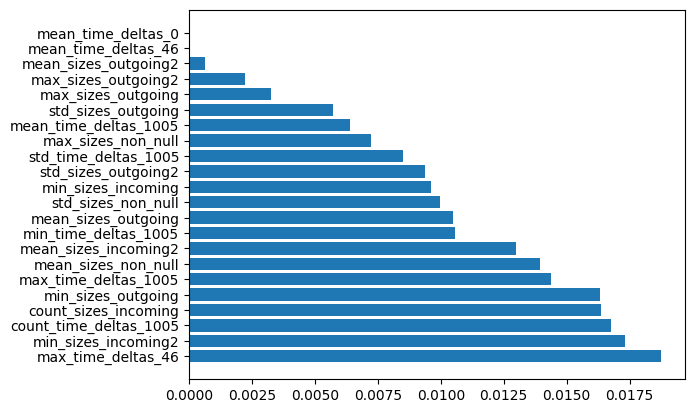

In [37]:
values, labels = zip(*(feature_importance[20:]))
plt.barh(range(len(labels)),values)
plt.yticks(range(len(values)),labels)
plt.show()